<center><h1> Linear Example: Dependence on Dimension

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from scipy import stats, linalg
import scipy as sp

from mud.util import transform_setup, transform_linear_map, std_from_equipment, createRandomLinearPair, createRandomLinearProblem
from mud.funs import mud_sol, map_sol

In [2]:
plt.rcParams['figure.figsize'] = 10,10
plt.rcParams['font.size'] = 16
fsize = 32

In [3]:
def numnonzero(x, tol=1E-4):
    return len(x[abs(x)<tol])

---

# Impact of Dimension for Various Choices of $\Sigma_\text{init}$
We sequentially incorporate $D=1, \dots , P$ dimensions into our QoI map and study the 2-norm between the true value that was used to generate the data and the analytical MUD/MAP points. 

In [4]:
def rand_problem(dim_input, dim_output, seed=27):
    np.random.seed(seed)
    lam_ref = np.random.rand(dim_input).reshape(-1,1)
    A = np.random.randn(dim_output, dim_input)
    b = np.random.randn(dim_output).reshape(-1,1)
    y = A@lam_ref + b
    return lam_ref, A, b, y

def rand_orth_problem(dim_input, dim_output, seed=27):
    np.random.seed(seed)
    lam_ref = np.random.rand(dim_input).reshape(-1,1)
    A = np.random.randn(dim_output, dim_input)
    A, _ = np.linalg.qr(A)
    b = np.random.randn(dim_output).reshape(-1,1)
    y = A@lam_ref + b
    return lam_ref, A, b, y

def iden_problem(dim_input, dim_output, seed=27):
    np.random.seed(seed)
    lam_ref = np.random.rand(dim_input).reshape(-1,1)
    A = np.random.randn(dim_output, dim_input)

    A = np.eye(dim_input)
#     b = np.random.randn(dim_output).reshape(-1,1)
    b = np.zeros(dim_output).reshape(-1,1)
    y = A@lam_ref + b
    return lam_ref, A, b, y

In [5]:
dim_input, dim_output = 100, 100
initial_mean = np.zeros(dim_input).reshape(-1,1)
randP = rand_problem
lam_ref, A, b, d = randP(dim_input, dim_output)
prefix='lin-cov'

In [6]:
from sklearn.datasets import make_spd_matrix
cov = np.eye(dim_input)
# cov = np.diag(np.random.rand(dim_input)+0.5)
# cov = make_spd_matrix(dim_input)

In [7]:
%%time
sols = {}
dim_output
tol_list = [10**(n) for n in np.linspace(-2,2,11)]
std_list = [std_from_equipment(tol) for tol in tol_list]
for std in std_list:
    sols[std] = []
    for o in range(1,dim_output+1, 1):
        _A = A[:o, :]
        _b = b[:o,:]
        _d = d[:o,:]
        _mud = mud_sol(_A, _b, _d, initial_mean, std**2*cov)
        _map = map_sol(_A, _b, _d, initial_mean, std**2*cov)
        _pin = (np.linalg.pinv(_A)@(_d-_b)).reshape(-1,1)
        sols[std].append((_mud, _map, _pin))

CPU times: user 6.49 s, sys: 13.3 s, total: 19.8 s
Wall time: 2.57 s


In [8]:
# c = np.linalg.cond(A)*np.linalg.norm(lam_ref)
c = 1
err_mud_list = [[np.linalg.norm(_m[0] - lam_ref)/c for _m in sols[std]] for std in std_list ] # output_dim+1 values of _m
err_map_list = [[np.linalg.norm(_m[1] - lam_ref)/c for _m in sols[std]] for std in std_list ]
err_pin_list = [[np.linalg.norm(_m[2] - lam_ref)/c for _m in sols[std]] for std in std_list ]

# c = np.linalg.cond(A)
c = np.linalg.norm(A)
err_Amud_list = [[np.linalg.norm(A@(_m[0] - lam_ref))/c for _m in sols[std]] for std in std_list ]
err_Amap_list = [[np.linalg.norm(A@(_m[1] - lam_ref))/c for _m in sols[std]] for std in std_list ]
err_Apin_list = [[np.linalg.norm(A@(_m[2] - lam_ref))/c for _m in sols[std]] for std in std_list ]

# measure # of components that agree
# err_mud_list = [[numnonzero(_m[0] - lam_ref) for _m in sols[std]] for std in std_list ]
# err_map_list = [[numnonzero(_m[1] - lam_ref) for _m in sols[std]] for std in std_list ]
# err_pin_list = [[numnonzero(_m[2] - lam_ref) for _m in sols[std]] for std in std_list ]

In [9]:
x, y = np.arange(1,dim_output,1), err_mud_list[0][0:-1]

slope, intercept = (np.linalg.pinv(np.vander(x, 2))@np.array(y).reshape(-1,1)).ravel()
regression = slope*x + intercept

---

## Surface Plot

In [10]:
X, Y = np.meshgrid(x,std_list)
ZU = np.array(err_mud_list)[:,1:100]
ZA = np.array(err_map_list)[:,1:100]

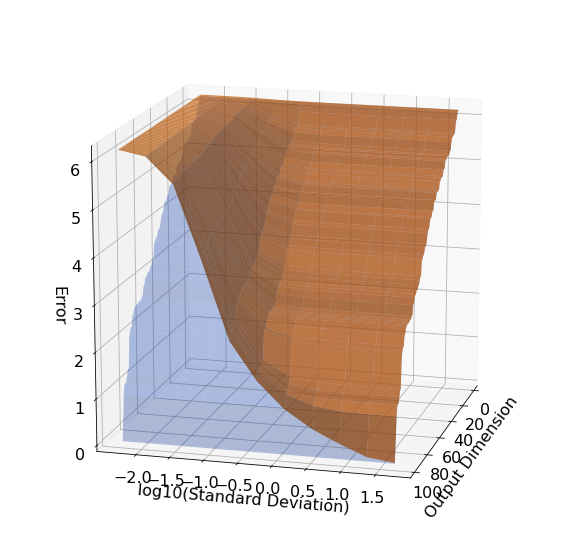

In [11]:
# import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X, np.log10(Y), ZU, alpha=0.3, color='xkcd:blue')
ax.plot_surface(X, np.log10(Y), ZA, alpha=0.7, color='xkcd:orange')
ax.set(ylabel='log10(Standard Deviation)', xlabel='Output Dimension', zlabel='Error')
# ax.set(yscale='log')
ax.view_init(15, 15)
plt.savefig(f'{prefix}-surface-error.pdf', bbox_inches='tight')
plt.show()

In [12]:
A

array([[-0.14442613,  0.5913527 , -0.03716775, ..., -1.79625846,
        -3.34150345, -0.4545531 ],
       [ 0.248305  , -0.39535091, -1.71989707, ..., -1.33606192,
        -2.03636495, -0.85577993],
       [ 0.21549853,  1.96140423,  0.08465965, ...,  0.39714751,
         1.02094614,  0.32272679],
       ...,
       [ 1.43992934,  1.56573951, -1.17772504, ..., -0.04730743,
         0.74283804, -1.03831669],
       [-0.21218781,  0.72939452, -0.04429446, ...,  0.19988364,
         0.07201491,  0.5466337 ],
       [ 1.12545997, -0.68868038, -2.55682028, ..., -0.04805287,
        -1.74081973, -1.35421832]])

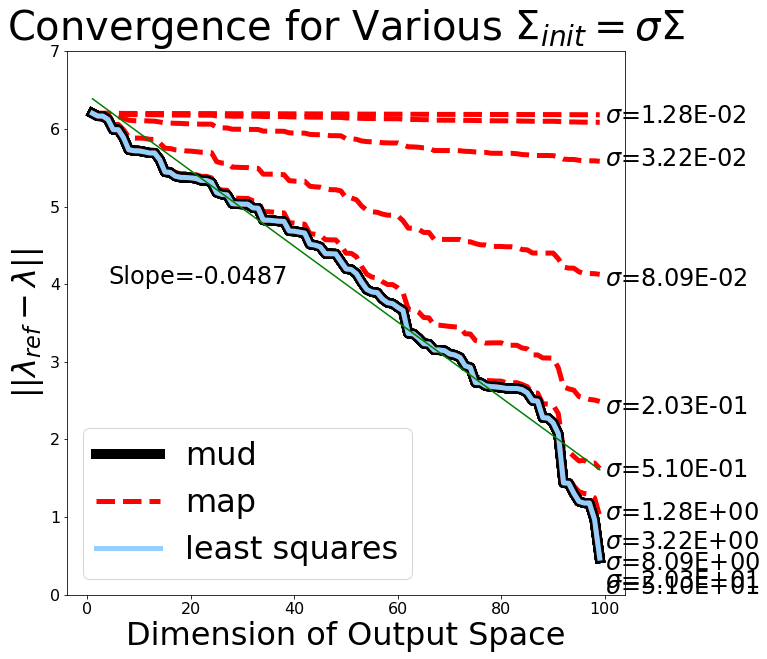

In [13]:
for idx, std in enumerate(std_list):
    if idx>0: plt.annotate(f"$\sigma$={std:1.2E}", (100, err_map_list[idx][-1]), fontsize=24)
    _err_mud = err_mud_list[idx]
    _err_map = err_map_list[idx]
    _err_pin = err_pin_list[idx]
    
    plt.plot(x,_err_mud[:-1], label='mud', c='k', lw=10)
    plt.plot(x,_err_map[:-1], label='map', c='r', ls='--', lw=5)
    plt.plot(x,_err_pin[:-1], label='lsq', c='xkcd:light blue', ls='-', lw=5)
plt.plot(x,regression, c='g', ls='-')
# plt.xlim(0,dim_output)
if 'id' in prefix:
    plt.title("Convergence for Various $\Sigma_{init} = \sigma I$", fontsize=1.25*fsize)
else:
    plt.title("Convergence for Various $\Sigma_{init} = \sigma \Sigma$", fontsize=1.25*fsize)# plt.yscale('log')
# plt.xscale('log')
plt.ylim(0, 7)
# plt.ylim(1E-4, 5E-2)
plt.ylabel("$||\lambda_{ref} - \lambda||$", fontsize=fsize)
plt.xlabel('Dimension of Output Space', fontsize=fsize)
plt.legend(['mud', 'map', 'least squares'], fontsize=fsize)
plt.annotate(f'Slope={slope:1.4f}', (4,4), fontsize=24)
plt.savefig(f'{prefix}-convergence-dimension.pdf', bbox_inches='tight')
plt.show()

In [14]:
print(c, slope)

99.40589967036126 -0.048749748174146026


#### Observations
These results appear to hold for random $A$'s generated with uniform and normal distributions, and even hold for $A=I$ (which actually fairs worse for the MAP solution, as do orthogonal maps)

ValueError: x and y must have same first dimension, but have shapes (101,) and (100,)

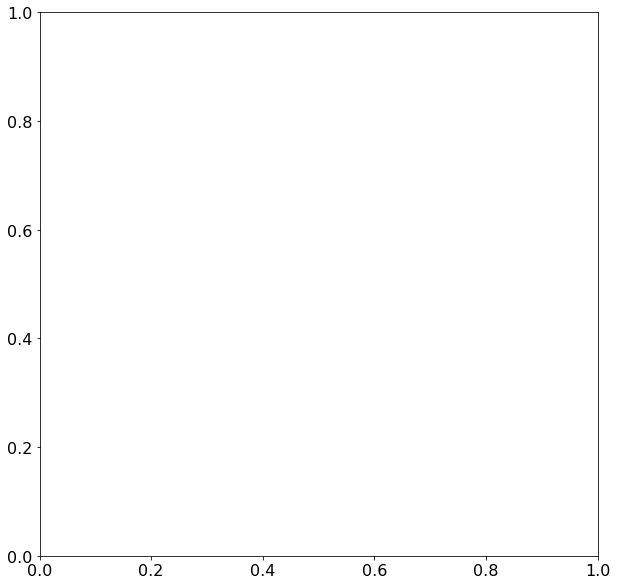

In [15]:
for idx, std in enumerate(std_list):
    _err_mud = err_Amud_list[idx]
    _err_map = err_Amap_list[idx]
    _err_pin = err_Apin_list[idx]
    
    plt.plot(np.arange(0, 1+dim_output),_err_mud[:], label='mud', c='k', lw=10)
    plt.plot(np.arange(0, 1+dim_output),_err_map[:], label='map', c='r', ls='--', lw=5)
    plt.plot(np.arange(0, 1+dim_output),_err_pin[:], label='lsq', c='xkcd:light blue', ls='-', lw=5)
# plt.plot(x,regression, c='g', ls='-')
# plt.xlim(0,dim_output)
if 'id' in prefix:
    plt.title("Convergence for Various $\Sigma_{init} = \sigma I$", fontsize=1.25*fsize)
else:
    plt.title("Convergence for Various $\Sigma_{init} = \sigma \Sigma$", fontsize=1.25*fsize)# plt.yscale('log')
# plt.xscale('log')
# plt.ylim(0, 6)
# plt.ylim(1E-4, 5E-2)
plt.ylabel("$\\frac{||A (\lambda_{ref} - \lambda) ||}{||A||}$", fontsize=fsize)
plt.xlabel('Dimension of Output Space', fontsize=fsize)
plt.legend(['mud', 'map', 'least squares'], fontsize=fsize)
# plt.annotate(f'Slope={slope:1.4f}', (4,4), fontsize=24)
plt.savefig(f'{prefix}-convergence-dimension-out.pdf', bbox_inches='tight')
plt.show()

In [ ]:
pin_mud_mismatch = np.vstack( [ [np.linalg.norm(_err_pin[n] - _err_mud[n]) for n in range(dim_input)] for _err_pin, _err_mud in zip(err_pin_list, err_mud_list)])
plt.plot(x, pin_mud_mismatch.T, c='k')
plt.xlabel('Dimension', fontsize=fsize)
plt.yscale('log')
# plt.xscale('log')
plt.ylabel('$||\lambda_{mud} - \lambda_{lsq}||$', fontsize=fsize)
# plt.title("MUD $\\approx$ Least Squares", fontsize=1.25*fsize)
plt.savefig(f"{prefix}-mud-leastsquares-error.pdf")
plt.show()